In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numdifftools
import scipy.optimize
import numpy as np
import yaml
import os
import uncertainties
import scipy.stats
import scipy.integrate
import pandas as pd
from tabulate import tabulate
from multiprocessing import Pool
from copy import copy

In [3]:
os.makedirs("../bcl_fits", exist_ok=True)

In [4]:
def init_plot_style():
    """Define the rcParams for the plot. Requires matplotlib to be imported as mpl."""
    my_rc_params = {
        "xtick.direction": "out",
        "xtick.major.size": 8.0,
        "xtick.minor.size": 4.0,
        "xtick.minor.visible": True,
        "xtick.major.width": 1.2,
        "xtick.minor.width": 0.9,
        "ytick.direction": "out",
        "ytick.major.size": 8.0,
        "ytick.minor.size": 4.0,
        "ytick.minor.visible": True,
        "ytick.major.width": 1.2,
        "ytick.minor.width": 0.9,
        "errorbar.capsize": 0,
        "axes.linewidth": 1.2,
        # "font.familiy": "serif",
        "font.size": 11,
        "axes.grid": False,
        "ytick.right": False,
        "xtick.top": False
    }
    for key in my_rc_params.keys():
        mpl.rcParams[key] = my_rc_params[key]

init_plot_style()

In [5]:
def perform_fit(chi2_function, x0, calculate_covariance=True):
    """Wrapper function to perform the fit and calcuate the covariance matrix in one go.
    
    Arguments:
        chi2_function: Function to be minimized.
        x0: Starting values for the fit.
        calculate_covariance: Do or do not calculate the covariance matrix. This is often time intensive and might be disabled for debugging.
    """
    result = scipy.optimize.minimize(
        chi2_function, x0=x0,
        method='SLSQP', tol=1e-7, options={'maxiter': 1e7}
    )
    if calculate_covariance:
        result.covariance = np.linalg.inv(numdifftools.Hessian(chi2_function)(result.x)/2) 
    return result

In [6]:
from eFFORT.SLBToU.BToVLNu import BToVLNuBCL
from eFFORT.utility import PDG

In [7]:
class Predictor:
    
    def __init__(self, bcl, lcsr_q2_points):
        self.bcl = bcl
        self.lcsr_q2_points = lcsr_q2_points
    
    def get_predictions(self, coefficients):
        self.bcl.coefficients = coefficients
        return np.array([
            *[self.bcl.A0(q2) for q2 in self.lcsr_q2_points[0]],
            *[self.bcl.A1(q2) for q2 in self.lcsr_q2_points[1]],
            *[self.bcl.A12(q2) for q2 in self.lcsr_q2_points[2]],
            *[self.bcl.V(q2) for q2 in self.lcsr_q2_points[3]],
            *[self.bcl.T1(q2) for q2 in self.lcsr_q2_points[4]],
            *[self.bcl.T2(q2) for q2 in self.lcsr_q2_points[5]],
            *[self.bcl.T23(q2) for q2 in self.lcsr_q2_points[6]],
        ])
    
    def get_theory_predictions(self, parameters, *binnings):
        """Helper function for chi2 evaluation."""
        self.bcl.V_ub = parameters[0]
        self.bcl.coefficients = parameters[1:]
        return np.array([
            [self.bcl.deltaGamma_deltaq2(l, u) *1e18  for l, u in binning] 
            for binning in binnings
        ])
    
    def get_theory_predictions_9p1(self, parameters, *binnings):
        """Helper function for chi2 evaluation for the 9+1 fit."""
        self.bcl.V_ub = parameters[0]
        self.bcl.coefficients = np.array([*np.zeros(2), *parameters[1:], *np.zeros(8)])
        return np.array([
            [self.bcl.deltaGamma_deltaq2(l, u) *1e18 for l, u in binning] 
            for binning in binnings
        ])
    
    def get_theory_predictions_9p1_at_q2_equal_0(self, parameters):
        """Helper function for chi2 evaluation for the 9+1 fit."""
        self.bcl.V_ub = parameters[0]
        self.bcl.coefficients = np.array([*np.zeros(2), *parameters[1:], *np.zeros(8)])
        return self.bcl.dGamma_dq2(1e-3) / scipy.integrate.quad(self.bcl.dGamma_dq2, self.bcl.q2min, self.bcl.q2max)[0]

    def get_theory_predictions_6p1(self, parameters, *binnings):
        """Helper function for chi2 evaluation for the 6+1 fit."""
        self.bcl.V_ub = parameters[0]
        self.bcl.coefficients = np.array([*np.zeros(2), parameters[1], parameters[2], 0, parameters[3], parameters[4], 0, parameters[5], parameters[6], 0, *np.zeros(8)])
        return np.array([
            [self.bcl.deltaGamma_deltaq2(l, u) *1e18 for l, u in binning] 
            for binning in binnings
        ])

In [8]:
lcsr_q2_points = np.array([
    np.array([7, 14]),  # A0
    np.array([0, 7, 14]),  # A1
    np.array([0, 7, 14]),  # A12
    np.array([0, 7, 14]),  # V
    np.array([0, 7, 14]),  # T1
    np.array([7, 14]),  # T2
    np.array([0, 7, 14]),  # T23
])

# B to Rho

In [9]:
m_V = 0.77526  # rho
V_ub = 3.65e-3 
predictor_BToVLNuBCL = Predictor(BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=V_ub), lcsr_q2_points)

In [10]:
# Measurements are given as deltaGamma / deltaq2
from epsfits.measurements import BaBarBToRho, BelleBToRho

babarBToRho = BaBarBToRho()
babar_bins = babarBToRho.bins
babar_central = babarBToRho.central *1e18 
babar_covariance = babarBToRho.covariance *1e18 *1e18

belleBToRho = BelleBToRho()
belle_charged_bins = belleBToRho.charged_bins
belle_charged_central = belleBToRho.charged_central *1e18 
belle_charged_covariance = belleBToRho.charged_covariance *1e18 *1e18

belle_neutral_bins = belleBToRho.neutral_bins
belle_neutral_central = belleBToRho.neutral_central *1e18
belle_neutral_covariance = belleBToRho.neutral_covariance *1e18 *1e18

# Calculate the inverse only once, not at every optimization step
babar_inverse = np.linalg.inv(babar_covariance)
belle_inverse_charged = np.linalg.inv(belle_charged_covariance)
belle_inverse_neutral = np.linalg.inv(belle_neutral_covariance)

In [11]:
# Read in legacy spectrum
with open("../legacy_spectra/legacy_spectrum_rho.yaml", "r") as f:
    legacy_spectrum = yaml.load(f, Loader=yaml.FullLoader)
legacy_bins = np.array(legacy_spectrum["bins"])
legacy_central = np.array(legacy_spectrum["central_values"])
legacy_covariance = np.array(legacy_spectrum["covariance_matrix"])

# Calculate the inverse only once, not at every optimization step
legacy_inverse = np.linalg.inv(legacy_covariance)

legacy_inverse_varied_q2 = {}
for i in range(0, len(legacy_central) ):
    legacy_inverse_varied_q2[i] = np.linalg.inv(legacy_covariance[:i+1, :i+1])

In [12]:
# Read in LCSR calculation
lcsr_coefficients = np.load('../../eFFORT/data/B{}_LCSR_central.npy'.format("rho"))
lcsr_coefficients_cov = np.load('../../eFFORT/data/B{}_LCSR_covariance.npy'.format("rho"))

# Cut out only the relevant form factors
lcsr_coefficients_9p1 = lcsr_coefficients[2:11]
lcsr_coefficients_cov_9p1 = lcsr_coefficients_cov[2:11, 2:11]

# Calculate the inverse only once, not at every optimization step
theory_inverse = np.linalg.inv(lcsr_coefficients_cov)
theory_inverse_9p1 = np.linalg.inv(lcsr_coefficients_cov_9p1)

In [13]:
# Draw toy for lcsr coefficients
sample = scipy.stats.multivariate_normal.rvs(lcsr_coefficients, lcsr_coefficients_cov, size=10000)
# Generate predictions with toy
toy = np.array([predictor_BToVLNuBCL.get_predictions(x) for x in sample]).transpose()
# Correlation matrix
correlation_matrix_ff_predictions = np.corrcoef(toy)
# Covariance matrix
stds = np.array([np.std(toy[i, :]) for i in range(len(toy[:, 0]))])
theory_ff_central = predictor_BToVLNuBCL.get_predictions(lcsr_coefficients)
theory_ff_covariance = correlation_matrix_ff_predictions * np.outer(stds, stds)
theory_ff_covariance_inverse = np.linalg.inv(theory_ff_covariance)

In [14]:
# Clean up a bit
del toy
del sample

## Fit: Legacy Spectrum, 19+1

In [15]:
def chi2_wrapper(x, n_bins):
    """Chi2 function for fits to legacy spectrum.
    
    Arguments:
        x: [Vub, 19 coefficients]
        n_bins: Number of bins to be fitted to the legacy spectrum.
    """
    legacy_theory = predictor_BToVLNuBCL.get_theory_predictions(x, legacy_bins[:n_bins])
    
    theory_res = lcsr_coefficients - x[1:]
    legacy_res = legacy_central[:n_bins] - legacy_theory

    return theory_res @ theory_inverse @ np.transpose(theory_res) \
            + legacy_res @ legacy_inverse_varied_q2[n_bins-1] @ np.transpose(legacy_res)

chi2_legacy = lambda x: chi2_wrapper(x, len(legacy_central))

In [16]:
%%time
result_legacy = perform_fit(chi2_legacy, x0=np.array([V_ub, *lcsr_coefficients]))

CPU times: user 3min 44s, sys: 186 ms, total: 3min 44s
Wall time: 3min 44s


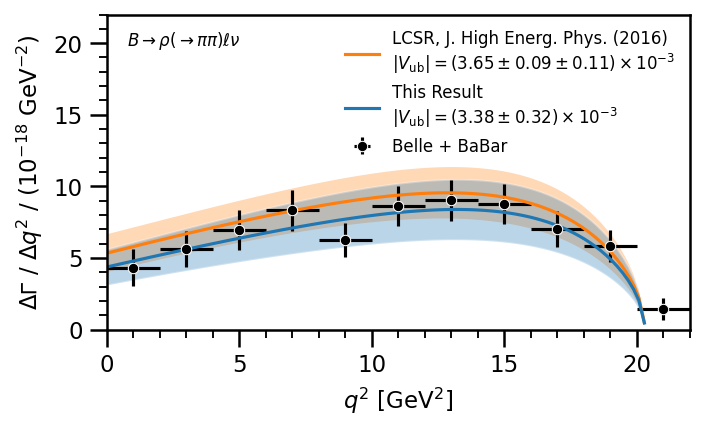

In [17]:
plotter_BToVLNuBCL = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=0)
q2 = np.linspace(plotter_BToVLNuBCL.q2min+1e-2, plotter_BToVLNuBCL.q2max-1e-2, num=100)

fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in legacy_bins],
    [c for c in legacy_central],
    yerr=[np.sqrt(legacy_covariance[i, i]) for i in range(0, len(legacy_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in legacy_bins],
    marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='black', label='Belle + BaBar'
)

# Plot HFLAV Vub + LCSR Coefficients
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(lcsr_coefficients, lcsr_coefficients_cov)
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(3.65e-3, (0.09e-3**2 + 0.11e-3**2)**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:orange", ls='solid',
        label="LCSR, J. High Energ. Phys. (2016)\n"+r"$|V_\mathrm{ub}| = (3.65 \pm 0.09 \pm 0.11) \times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:orange", alpha=0.3)

# Plot Fit Result
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(result_legacy.x[1:], result_legacy.covariance[1:, 1:])
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy.x[0], result_legacy.covariance[0, 0]**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:blue", ls='solid',
        label="This Result\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy.x[0]:.2f} \pm {1e3*result_legacy.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:blue", alpha=0.3, edgecolor="white", lw=1, ls="solid")

ax.set_xlim(0, 22)
ax.set_ylim(0, 22)
ax.annotate(
    r'$B \rightarrow \rho (\rightarrow \pi \pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'$\Delta \mathcal{\Gamma}$ / $\Delta q^2$ / ($10^{-18}$ GeV$^{-2}$)')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=8)
plt.tight_layout()
plt.savefig("../bcl_fits/q2_vs_rate_rho.png")
plt.savefig("../bcl_fits/q2_vs_rate_rho.pdf")
plt.show()
plt.close()

In [18]:
os.makedirs("../fit_results", exist_ok=True)

with open("../fit_results/fit_result_rho.yaml", "w") as f:
    yaml.dump({
    "central_values": result_legacy.x.tolist(),
    "uncertainties": (result_legacy.covariance.diagonal()**0.5).tolist(),
    "covariance_matrix": result_legacy.covariance.tolist(),
    "correlation_matrix": (result_legacy.covariance / np.outer(result_legacy.covariance.diagonal()**0.5, result_legacy.covariance.diagonal()**0.5)).tolist()
    }, f)

## Fit: Legacy Spectrum, 19+1, use sampled Form Factors at q2={0, 7, 14}

In [19]:
def chi2_legacy_sampled_ff(x):
    legacy_theory = predictor_BToVLNuBCL.get_theory_predictions(x, legacy_bins)

    theory_res = theory_ff_central - predictor_BToVLNuBCL.get_predictions(x[1:])
    legacy_res = legacy_central - legacy_theory

    return theory_res @ theory_ff_covariance_inverse @ np.transpose(theory_res) \
            + legacy_res @ legacy_inverse @ np.transpose(legacy_res)

In [20]:
%%time
result_legacy_sampled_ff = perform_fit(chi2_legacy_sampled_ff, x0=np.array([V_ub, *lcsr_coefficients]), calculate_covariance=True)

CPU times: user 3min 27s, sys: 58 µs, total: 3min 27s
Wall time: 3min 27s


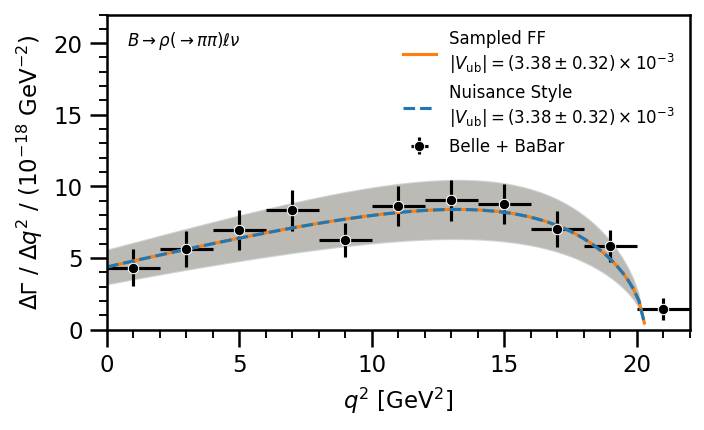

In [21]:
plotter_BToVLNuBCL = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=0)
q2 = np.linspace(plotter_BToVLNuBCL.q2min+1e-2, plotter_BToVLNuBCL.q2max-1e-2, num=100)

fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in legacy_bins],
    [c for c in legacy_central],
    yerr=[np.sqrt(legacy_covariance[i, i]) for i in range(0, len(legacy_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in legacy_bins],
    marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='black', label='Belle + BaBar'
)

# Plot HFLAV Vub + LCSR Coefficients
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(result_legacy_sampled_ff.x[1:], result_legacy_sampled_ff.covariance[1:, 1:])
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy.x[0], result_legacy_sampled_ff.covariance[0, 0]**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:orange", ls='solid',
        label="Sampled FF\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy_sampled_ff.x[0]:.2f} \pm {1e3*result_legacy_sampled_ff.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:orange", alpha=0.3, edgecolor="white", lw=1, ls="solid")
# Plot Fit Result
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(result_legacy.x[1:], result_legacy.covariance[1:, 1:])
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy.x[0], result_legacy.covariance[0, 0]**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:blue", ls='dashed',
        label="Nuisance Style\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy.x[0]:.2f} \pm {1e3*result_legacy.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:blue", alpha=0.3, edgecolor="white", lw=1, ls="solid")

ax.set_xlim(0, 22)
ax.set_ylim(0, 22)
ax.annotate(
    r'$B \rightarrow \rho (\rightarrow \pi \pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'$\Delta \mathcal{\Gamma}$ / $\Delta q^2$ / ($10^{-18}$ GeV$^{-2}$)')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

## Fit: Legacy Spectrum, 19+1, vary q2 ranges

In [22]:
def pool_wrapper(i):
    return perform_fit(lambda x: chi2_wrapper(x, i+1), x0=np.array([V_ub, *lcsr_coefficients]), calculate_covariance=True)

pool = Pool(os.cpu_count())
tmp = pool.map(pool_wrapper, range(0, len(legacy_central)))

result_legacy_varied_q2_fit = {}
for i in range(0, len(legacy_central)):
    result_legacy_varied_q2_fit[i] = tmp[i]
    
del tmp
del pool_wrapper

In [23]:
# Copy variable for later plotting
result_legacy_varied_q2_fit_rho = copy(result_legacy_varied_q2_fit)

## Fit: Legacy Spectrum, Vub only

In this fit the uncertainty of the LCSR coefficients is not considered. That is why the uncertainty on |Vub| is so small.

In [24]:
def chi2_legacy_vub_only1(x, n_bins):
    """Chi2 function for fits to legacy spectrum.
    
    Arguments:
        x: [Vub,]
        n_bins: Number of bins to be fitted to the legacy spectrum.
    """
    legacy_theory = predictor_BToVLNuBCL.get_theory_predictions(np.array([x, *lcsr_coefficients]), legacy_bins[:n_bins])
    legacy_res = legacy_central[:n_bins] - legacy_theory

    return legacy_res @ legacy_inverse_varied_q2[n_bins-1] @ np.transpose(legacy_res)

In [25]:
result_legacy_vub_only_varied_q2_fit = {}
for i in range(0, len(legacy_central)):
    result_legacy_vub_only_varied_q2_fit[i] = perform_fit(lambda x: chi2_legacy_vub_only1(x, i+1), x0=np.array([V_ub,]), calculate_covariance=True)

## Summary: q2 Variation

In [26]:
print("q2max \t\t BCL(19+1) \t\t\t BCL(Vub only)")
for i in range(0, len(legacy_central)):
    print(f"q2 < {legacy_bins[i][1]}  \t |Vub| = {1e3*result_legacy_varied_q2_fit[i].x[0]:.2f} +- {1e3*result_legacy_varied_q2_fit[i].covariance[0, 0]**0.5:.2f}\
    \t |Vub| = {1e3*result_legacy_vub_only_varied_q2_fit[i].x[0]:.2f} +- {1e3*result_legacy_vub_only_varied_q2_fit[i].covariance[0, 0]**0.5:.2f} ")

q2max 		 BCL(19+1) 			 BCL(Vub only)
q2 < 2  	 |Vub| = 3.16 +- 0.59    	 |Vub| = 3.16 +- 0.48 
q2 < 4  	 |Vub| = 3.28 +- 0.43    	 |Vub| = 3.27 +- 0.27 
q2 < 6  	 |Vub| = 3.38 +- 0.40    	 |Vub| = 3.35 +- 0.23 
q2 < 8  	 |Vub| = 3.50 +- 0.39    	 |Vub| = 3.44 +- 0.20 
q2 < 10  	 |Vub| = 3.32 +- 0.34    	 |Vub| = 3.32 +- 0.18 
q2 < 12  	 |Vub| = 3.34 +- 0.33    	 |Vub| = 3.34 +- 0.17 
q2 < 14  	 |Vub| = 3.37 +- 0.33    	 |Vub| = 3.36 +- 0.16 
q2 < 16  	 |Vub| = 3.39 +- 0.33    	 |Vub| = 3.39 +- 0.15 
q2 < 18  	 |Vub| = 3.39 +- 0.33    	 |Vub| = 3.39 +- 0.15 
q2 < 20  	 |Vub| = 3.38 +- 0.32    	 |Vub| = 3.40 +- 0.15 
q2 < 22  	 |Vub| = 3.38 +- 0.32    	 |Vub| = 3.40 +- 0.15 


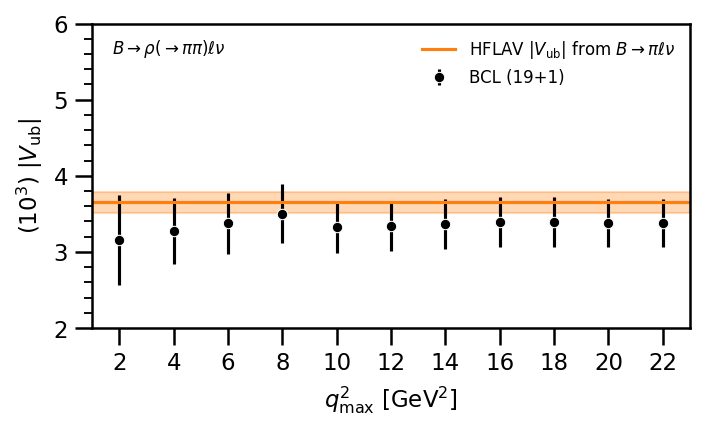

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

x = range(0, len(legacy_central))
ax.errorbar(
    x,
    [1e3 * result_legacy_varied_q2_fit[i].x[0] for i in x],
    yerr=[1e3 * result_legacy_varied_q2_fit[i].covariance[0, 0]**0.5 for i in x],
    marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='black', label='BCL (19+1)'
)

# ax.errorbar(
#     [tmp+0.1 for tmp in x],
#     [1e3 * result_legacy_vub_only_varied_q2_fit[i].x[0] for i in x],
#     yerr=[1e3 * result_legacy_vub_only_varied_q2_fit[i].covariance[0, 0]**0.5 for i in x],
#     marker='v', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
#     ls='', lw=lw, color='tab:blue', label='BCL ($|V_\mathrm{ub}|$ only)'
# )

_vub = 1e3 * uncertainties.ufloat(3.65e-3, (0.09e-3**2 + 0.11e-3**2)**0.5)

ax.axhline(_vub.nominal_value,
        color="tab:orange", ls='solid',
        # label="LCSR, J. High Energ. Phys. (2016)\n"+r"$|V_\mathrm{ub}| = (3.65 \pm 0.09 \pm 0.11) \times 10^{-3}$")
        label=r"HFLAV $|V_\mathrm{ub}|$ from $B \rightarrow \pi \ell \nu$")
ax.fill_between([min(x)-0.5, max(x)+0.5], _vub.nominal_value - _vub.std_dev, _vub.nominal_value + _vub.std_dev, alpha=0.3, color="tab:orange")

del _vub

ax.set_xlim(min(x)-0.5, max(x)+0.5)
ax.set_ylim(2, 6)
ax.annotate(
    r'$B \rightarrow \rho (\rightarrow \pi \pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 

ax.set_xticks(x, minor=False)
ax.set_xticklabels([f"{legacy_bins[i][1]}" for i in x], rotation='horizontal')
ax.tick_params(axis='x', which='minor', bottom=False)

ax.set_xlabel(r'$q^2_\mathrm{max}$ [GeV$^2$]')
ax.set_ylabel(r'$(10^3)$ $|V_\mathrm{ub}|$')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

## Fit: Individual Spectra, 19+1

In [28]:
def chi2_individual(x):
    babar_theory, belle_theory_charged, belle_theory_neutral = predictor_BToVLNuBCL.get_theory_predictions(
        x, babar_bins, belle_charged_bins, belle_neutral_bins)

    theory_res = lcsr_coefficients - x[1:]
    babar_res = babar_central - babar_theory
    belle_res_charged = belle_charged_central - belle_theory_charged
    belle_res_neutral = belle_neutral_central - belle_theory_neutral

    return theory_res @ theory_inverse @ np.transpose(theory_res) \
         + babar_res @ babar_inverse @ np.transpose(babar_res)\
         + belle_res_charged @ belle_inverse_charged @ np.transpose(belle_res_charged)\
         + belle_res_neutral @ belle_inverse_neutral @ np.transpose(belle_res_neutral)

In [29]:
%%time
result_individual = perform_fit(chi2_individual, x0=np.array([V_ub, *lcsr_coefficients]))

CPU times: user 8min 39s, sys: 645 ms, total: 8min 40s
Wall time: 8min 39s


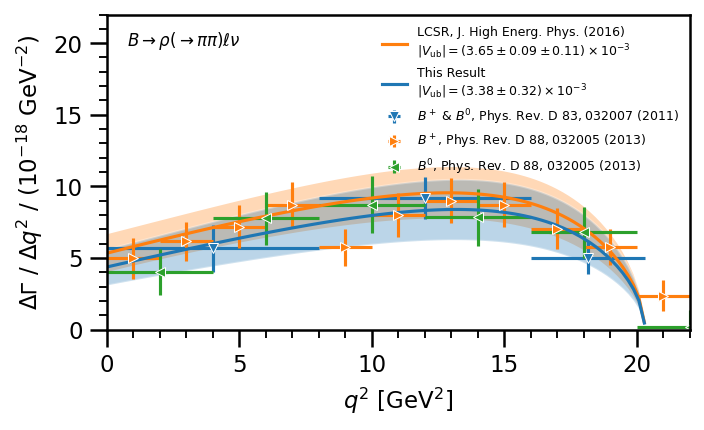

In [30]:
plotter_BToVLNuBCL = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=0)
q2 = np.linspace(plotter_BToVLNuBCL.q2min+1e-2, plotter_BToVLNuBCL.q2max-1e-2, num=100)

fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in babar_bins],
    [c for c in babar_central],
    yerr=[np.sqrt(babar_covariance[i, i]) for i in range(0, len(babar_bins))],
    xerr=[((b[1] - b[0]) / 2) for b in babar_bins],
    marker='v', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, label=r'$B^+$ & $B^0$, Phys. Rev. D 83, 032007 (2011)',
)

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in belle_charged_bins],
    [c for c in belle_charged_central],
    yerr=[np.sqrt(belle_charged_covariance[i, i]) for i in range(0, len(belle_charged_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in belle_charged_bins],
    marker='>', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, label=r'$B^+$, Phys. Rev. D 88, 032005 (2013)'
)

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in belle_neutral_bins],
    [c for c in belle_neutral_central],
    yerr=[np.sqrt(belle_neutral_covariance[i, i]) for i in range(0, len(belle_neutral_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in belle_neutral_bins],
    marker='<', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, label=r'$B^0$, Phys. Rev. D 88, 032005 (2013)'
)

# Plot HFLAV Vub + LCSR Coefficients
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(lcsr_coefficients, lcsr_coefficients_cov)
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(3.65e-3, (0.09e-3**2 + 0.11e-3**2)**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:orange", ls='solid',
        label="LCSR, J. High Energ. Phys. (2016)\n"+r"$|V_\mathrm{ub}| = (3.65 \pm 0.09 \pm 0.11) \times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:orange", alpha=0.3)

# Plot Fit Result
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(result_legacy.x[1:], result_legacy.covariance[1:, 1:])
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy.x[0], result_legacy.covariance[0, 0]**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:blue", ls='solid',
        label="This Result\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy.x[0]:.2f} \pm {1e3*result_legacy.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:blue", alpha=0.3, edgecolor="white", lw=1, ls="solid")

ax.set_xlim(0, 22)
ax.set_ylim(0, 22)
ax.annotate(
    r'$B \rightarrow \rho (\rightarrow \pi \pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'$\Delta \mathcal{\Gamma}$ / $\Delta q^2$ / ($10^{-18}$ GeV$^{-2}$)')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=6)
plt.tight_layout()
plt.show()
plt.close()

## Fit: Legacy Spectrum, 9+1

In [31]:
def chi2_legacy_9p1(x):
    legacy_theory = predictor_BToVLNuBCL.get_theory_predictions_9p1(x, legacy_bins)
    
    theory_res = lcsr_coefficients_9p1 - x[1:]
    legacy_res = legacy_central - legacy_theory

    return theory_res @ theory_inverse_9p1 @ np.transpose(theory_res) \
            + legacy_res @ legacy_inverse @ np.transpose(legacy_res)

In [32]:
%%time
result_legacy_9p1 = perform_fit(chi2_legacy_9p1, x0=np.array([V_ub, *lcsr_coefficients_9p1]))

CPU times: user 58.9 s, sys: 148 ms, total: 59.1 s
Wall time: 58.9 s


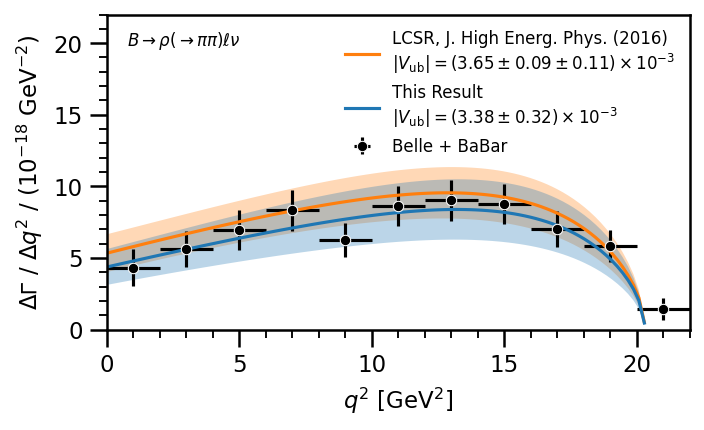

In [33]:
plotter_BToVLNuBCL = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=0)
q2 = np.linspace(plotter_BToVLNuBCL.q2min+1e-2, plotter_BToVLNuBCL.q2max-1e-2, num=100)

fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in legacy_bins],
    [c for c in legacy_central],
    yerr=[np.sqrt(legacy_covariance[i, i]) for i in range(0, len(legacy_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in legacy_bins],
    marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='black', label='Belle + BaBar'
)

# Plot HFLAV Vub + LCSR Coefficients
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(lcsr_coefficients, lcsr_coefficients_cov)
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(3.65e-3, (0.09e-3**2 + 0.11e-3**2)**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:orange", ls='solid',
        label="LCSR, J. High Energ. Phys. (2016)\n"+r"$|V_\mathrm{ub}| = (3.65 \pm 0.09 \pm 0.11) \times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:orange", alpha=0.3)

# Create padded vectors so the class can handle it
coefficients = np.array([*np.zeros(2), *result_legacy_9p1.x[1:], *np.zeros(8)])
coefficients_cov = np.zeros(lcsr_coefficients_cov.shape)
coefficients_cov[2:11, 2:11] = result_legacy_9p1.covariance[1:, 1:]

# Plot Fit Result
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(coefficients, coefficients_cov)
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy_9p1.x[0], result_legacy_9p1.covariance[0, 0]**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:blue", ls='solid',
        label="This Result\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy_9p1.x[0]:.2f} \pm {1e3*result_legacy_9p1.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:blue", alpha=0.3)

ax.set_xlim(0, 22)
ax.set_ylim(0, 22)
ax.annotate(
    r'$B \rightarrow \rho (\rightarrow \pi \pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'$\Delta \mathcal{\Gamma}$ / $\Delta q^2$ / ($10^{-18}$ GeV$^{-2}$)')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

## Summary: Cross-Checks

In [34]:
# label
parameter_labels = [
    r'$|V_\mathrm{ub}|$',
    r'$\alpha_1^{A_0}$', r'$\alpha_2^{A_0}$',
    r'$\alpha_0^{A_1}$', r'$\alpha_1^{A_1}$', r'$\alpha_2^{A_1}$',
    r'$\alpha_0^{A_{12}}$', r'$\alpha_1^{A_{12}}$', r'$\alpha_2^{A_{12}}$',
    r'$\alpha_0^{V}$', r'$\alpha_1^{V}$', r'$\alpha_2^{V}$',
    r'$\alpha_1^{T_1}$', r'$\alpha_2^{T_1}$',
    r'$\alpha_0^{T_2}$', r'$\alpha_1^{T_2}$', r'$\alpha_2^{T_2}$',
    r'$\alpha_0^{T_{23}}$', r'$\alpha_1^{T_{23}}$', r'$\alpha_2^{T_{23}}$',
]

# _lcsr_hflav
_central = np.array([3.65e-3, *lcsr_coefficients])
_cov = np.zeros(result_legacy.covariance.shape)
_cov[1:, 1:] = lcsr_coefficients_cov
_cov[0, 0] = (0.09e-3**2 + 0.11e-3**2)
_lcsr_hflav = uncertainties.correlated_values(_central, _cov)

# _result_legacy
_result_legacy = uncertainties.correlated_values(result_legacy.x, result_legacy.covariance)

# _result_legacy_sampled_ff
_result_legacy_sampled_ff = uncertainties.correlated_values(result_legacy_sampled_ff.x, result_legacy_sampled_ff.covariance)

# _result_individual
_result_individual = uncertainties.correlated_values(result_individual.x, result_individual.covariance)

# _result_legacy_9p1
_central = np.array([result_legacy_9p1.x[0], *np.zeros(2), *result_legacy_9p1.x[1:], *np.zeros(8)])
_cov = np.zeros(result_legacy.covariance.shape)
_cov[3:12, 3:12] = result_legacy_9p1.covariance[1:, 1:]
_cov[0, :] = np.array([result_legacy_9p1.covariance[0, 0], *np.zeros(2), *result_legacy_9p1.covariance[0, 1:], *np.zeros(8)])
_cov[:, 0] = _cov[0, :]
_result_legacy_9p1 = uncertainties.correlated_values(_central, _cov)

In [35]:
_result = pd.DataFrame.from_dict({
    "label": parameter_labels,
    "_lcsr_hflav": _lcsr_hflav,
    "_result_legacy": _result_legacy,
    "_result_legacy_sampled_ff": _result_legacy_sampled_ff,
    "_result_individual": _result_individual,
    "_result_legacy_9p1": _result_legacy_9p1,
})

In [36]:
print(tabulate(_result, headers=_result.columns, showindex=False, tablefmt="latex_raw"))

\begin{tabular}{llllll}
\hline
 label               & _lcsr_hflav       & _result_legacy    & _result_legacy_sampled_ff   & _result_individual   & _result_legacy_9p1   \\
\hline
 $|V_\mathrm{ub}|$   & 0.00365+/-0.00014 & 0.00338+/-0.00032 & 0.00338+/-0.00032           & 0.00339+/-0.00032    & 0.00338+/-0.00032    \\
 $\alpha_1^{A_0}$    & -0.83+/-0.20      & -0.87+/-0.19      & -0.87+/-0.19                & -0.86+/-0.19         & 0.0+/-0              \\
 $\alpha_2^{A_0}$    & 1.3+/-1.0         & 1.5+/-1.0         & 1.5+/-1.0                   & 1.4+/-1.0            & 0.0+/-0              \\
 $\alpha_0^{A_1}$    & 0.262+/-0.026     & 0.266+/-0.025     & 0.266+/-0.025               & 0.265+/-0.025        & 0.266+/-0.025        \\
 $\alpha_1^{A_1}$    & 0.39+/-0.14       & 0.37+/-0.13       & 0.37+/-0.13                 & 0.38+/-0.13          & 0.37+/-0.13          \\
 $\alpha_2^{A_1}$    & 0.2+/-0.4         & 0.2+/-0.4         & 0.2+/-0.4                   & 0.2+/-0.4            & 0.2+/-

# B to Omega

In [37]:
m_V = 0.78265  # omega
V_ub = 3.65e-3 
predictor_BToVLNuBCL = Predictor(BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=V_ub), lcsr_q2_points)

In [38]:
# Measurements are given as deltaGamma / deltaq2
from epsfits.measurements import BaBarBToOmega, BelleBToOmega

babarBToOmega = BaBarBToOmega()
babar_bins = babarBToOmega.bins
babar_central = babarBToOmega.central *1e18 
babar_covariance = babarBToOmega.covariance *1e18 *1e18

belleBToOmega = BelleBToOmega()
belle_bins = belleBToOmega.bins
belle_central = belleBToOmega.central *1e18 
belle_covariance = belleBToOmega.covariance *1e18 *1e18

# Calculate the inverse only once, not at every optimization step
babar_inverse = np.linalg.inv(babar_covariance)
belle_inverse = np.linalg.inv(belle_covariance)

In [39]:
# Read in legacy spectrum
with open("../legacy_spectra/legacy_spectrum_omega.yaml", "r") as f:
    legacy_spectrum = yaml.load(f, Loader=yaml.FullLoader)
legacy_bins = np.array(legacy_spectrum["bins"])
legacy_central = np.array(legacy_spectrum["central_values"])
legacy_covariance = np.array(legacy_spectrum["covariance_matrix"])

# Calculate the inverse only once, not at every optimization step
legacy_inverse = np.linalg.inv(legacy_covariance)

legacy_inverse_varied_q2 = {}
for i in range(0, len(legacy_central) ):
    legacy_inverse_varied_q2[i] = np.linalg.inv(legacy_covariance[:i+1, :i+1])

In [40]:
# Read in LCSR calculation
lcsr_coefficients = np.load('../../eFFORT/data/B{}_LCSR_central.npy'.format("omega"))
lcsr_coefficients_cov = np.load('../../eFFORT/data/B{}_LCSR_covariance.npy'.format("omega"))

# Cut out only the relevant form factors
lcsr_coefficients_9p1 = lcsr_coefficients[2:11]
lcsr_coefficients_cov_9p1 = lcsr_coefficients_cov[2:11, 2:11]

# Calculate the inverse only once, not at every optimization step
theory_inverse = np.linalg.inv(lcsr_coefficients_cov)
theory_inverse_9p1 = np.linalg.inv(lcsr_coefficients_cov_9p1)

In [41]:
# Draw toy for lcsr coefficients
sample = scipy.stats.multivariate_normal.rvs(lcsr_coefficients, lcsr_coefficients_cov, size=10000)
# Generate predictions with toy
toy = np.array([predictor_BToVLNuBCL.get_predictions(x) for x in sample]).transpose()
# Correlation matrix
correlation_matrix_ff_predictions = np.corrcoef(toy)
# Covariance matrix
stds = np.array([np.std(toy[i, :]) for i in range(len(toy[:, 0]))])
theory_ff_central = predictor_BToVLNuBCL.get_predictions(lcsr_coefficients)
theory_ff_covariance = correlation_matrix_ff_predictions * np.outer(stds, stds)
theory_ff_covariance_inverse = np.linalg.inv(theory_ff_covariance)

In [42]:
# Clean up a bit
del toy
del sample

## Fit: Legacy Spectrum, 19+1

In [43]:
def chi2_wrapper(x, n_bins):
    """Chi2 function for fits to legacy spectrum.
    
    Arguments:
        x: [Vub, 19 coefficients]
        n_bins: Number of bins to be fitted to the legacy spectrum.
    """
    legacy_theory = predictor_BToVLNuBCL.get_theory_predictions(x, legacy_bins[:n_bins])
    
    theory_res = lcsr_coefficients - x[1:]
    legacy_res = legacy_central[:n_bins] - legacy_theory

    return theory_res @ theory_inverse @ np.transpose(theory_res) \
            + legacy_res @ legacy_inverse_varied_q2[n_bins-1] @ np.transpose(legacy_res)

chi2_legacy = lambda x: chi2_wrapper(x, len(legacy_central))

In [44]:
%%time
result_legacy = perform_fit(chi2_legacy, x0=np.array([V_ub, *lcsr_coefficients]))

CPU times: user 3min 49s, sys: 253 ms, total: 3min 49s
Wall time: 3min 48s


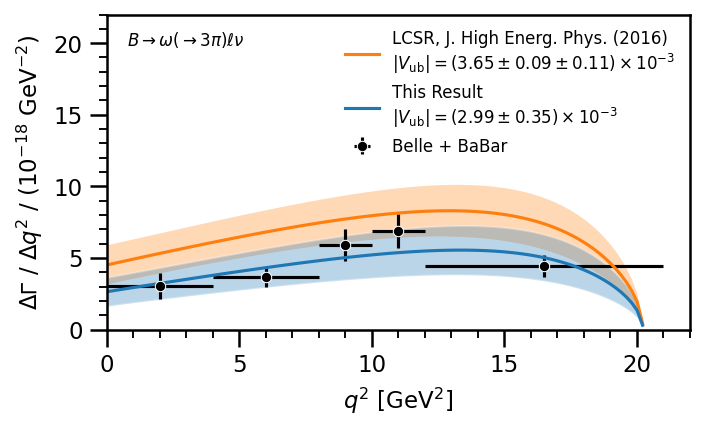

In [45]:
plotter_BToVLNuBCL = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=0)
q2 = np.linspace(plotter_BToVLNuBCL.q2min+1e-2, plotter_BToVLNuBCL.q2max-1e-2, num=100)

fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in legacy_bins],
    [c for c in legacy_central],
    yerr=[np.sqrt(legacy_covariance[i, i]) for i in range(0, len(legacy_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in legacy_bins],
    marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='black', label='Belle + BaBar'
)

# Plot HFLAV Vub + LCSR Coefficients
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(lcsr_coefficients, lcsr_coefficients_cov)
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(3.65e-3, (0.09e-3**2 + 0.11e-3**2)**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:orange", ls='solid',
        label="LCSR, J. High Energ. Phys. (2016)\n"+r"$|V_\mathrm{ub}| = (3.65 \pm 0.09 \pm 0.11) \times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:orange", alpha=0.3)

# Plot Fit Result
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(result_legacy.x[1:], result_legacy.covariance[1:, 1:])
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy.x[0], result_legacy.covariance[0, 0]**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:blue", ls='solid',
        label="This Result\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy.x[0]:.2f} \pm {1e3*result_legacy.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:blue", alpha=0.3, edgecolor="white", lw=1, ls="solid")

ax.set_xlim(0, 22)
ax.set_ylim(0, 22)
ax.annotate(
    r'$B \rightarrow \omega (\rightarrow 3\pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'$\Delta \mathcal{\Gamma}$ / $\Delta q^2$ / ($10^{-18}$ GeV$^{-2}$)')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=8)
plt.tight_layout()
plt.savefig("../bcl_fits/q2_vs_rate_omega.png")
plt.savefig("../bcl_fits/q2_vs_rate_omega.pdf")
plt.show()
plt.close()

In [46]:
os.makedirs("../fit_results", exist_ok=True)

with open("../fit_results/fit_result_omega.yaml", "w") as f:
    yaml.dump({
    "central_values": result_legacy.x.tolist(),
    "uncertainties": (result_legacy.covariance.diagonal()**0.5).tolist(),
    "covariance_matrix": result_legacy.covariance.tolist(),
    "correlation_matrix": (result_legacy.covariance / np.outer(result_legacy.covariance.diagonal()**0.5, result_legacy.covariance.diagonal()**0.5)).tolist()
    }, f)

## Fit: Legacy Spectrum, 19+1, use sampled Form Factors at q2={0, 7, 14}

In [47]:
def chi2_legacy_sampled_ff(x):
    legacy_theory = predictor_BToVLNuBCL.get_theory_predictions(x, legacy_bins)

    theory_res = theory_ff_central - predictor_BToVLNuBCL.get_predictions(x[1:])
    legacy_res = legacy_central - legacy_theory

    return theory_res @ theory_ff_covariance_inverse @ np.transpose(theory_res) \
            + legacy_res @ legacy_inverse @ np.transpose(legacy_res)

In [48]:
%%time
result_legacy_sampled_ff = perform_fit(chi2_legacy_sampled_ff, x0=np.array([V_ub, *lcsr_coefficients]), calculate_covariance=True)

CPU times: user 4min 2s, sys: 324 ms, total: 4min 2s
Wall time: 4min 2s


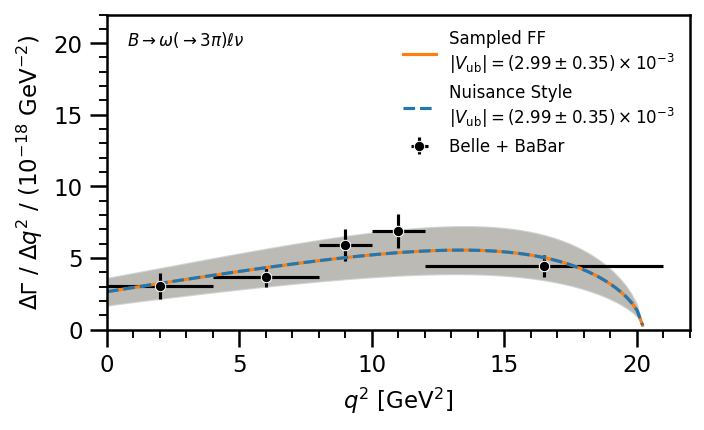

In [49]:
plotter_BToVLNuBCL = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=0)
q2 = np.linspace(plotter_BToVLNuBCL.q2min+1e-2, plotter_BToVLNuBCL.q2max-1e-2, num=100)

fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in legacy_bins],
    [c for c in legacy_central],
    yerr=[np.sqrt(legacy_covariance[i, i]) for i in range(0, len(legacy_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in legacy_bins],
    marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='black', label='Belle + BaBar'
)

# Plot HFLAV Vub + LCSR Coefficients
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(result_legacy_sampled_ff.x[1:], result_legacy_sampled_ff.covariance[1:, 1:])
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy.x[0], result_legacy_sampled_ff.covariance[0, 0]**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:orange", ls='solid',
        label="Sampled FF\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy_sampled_ff.x[0]:.2f} \pm {1e3*result_legacy_sampled_ff.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:orange", alpha=0.3, edgecolor="white", lw=1, ls="solid")
# Plot Fit Result
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(result_legacy.x[1:], result_legacy.covariance[1:, 1:])
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy.x[0], result_legacy.covariance[0, 0]**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:blue", ls='dashed',
        label="Nuisance Style\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy.x[0]:.2f} \pm {1e3*result_legacy.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:blue", alpha=0.3, edgecolor="white", lw=1, ls="solid")

ax.set_xlim(0, 22)
ax.set_ylim(0, 22)
ax.annotate(
    r'$B \rightarrow \omega (\rightarrow 3\pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'$\Delta \mathcal{\Gamma}$ / $\Delta q^2$ / ($10^{-18}$ GeV$^{-2}$)')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

## Fit: Legacy Spectrum, 19+1, vary q2 ranges

In [50]:
def pool_wrapper(i):
    return perform_fit(lambda x: chi2_wrapper(x, i+1), x0=np.array([V_ub, *lcsr_coefficients]), calculate_covariance=True)

pool = Pool(os.cpu_count())
tmp = pool.map(pool_wrapper, range(0, len(legacy_central)))

result_legacy_varied_q2_fit = {}
for i in range(0, len(legacy_central)):
    result_legacy_varied_q2_fit[i] = tmp[i]
    
del tmp
del pool_wrapper

In [51]:
# Copy variable for later plotting
result_legacy_varied_q2_fit_omega = copy(result_legacy_varied_q2_fit)

## Summary: q2 variation

In [52]:
print("q2max \t\t BCL(19+1)")
for i in range(0, len(legacy_central)):
    print(f"q2 < {legacy_bins[i][1]}  \t |Vub| = {1e3*result_legacy_varied_q2_fit[i].x[0]:.2f} +- {1e3*result_legacy_varied_q2_fit[i].covariance[0, 0]**0.5:.2f}")

q2max 		 BCL(19+1)
q2 < 4  	 |Vub| = 2.75 +- 0.54
q2 < 8  	 |Vub| = 2.69 +- 0.36
q2 < 10  	 |Vub| = 2.85 +- 0.36
q2 < 12  	 |Vub| = 3.02 +- 0.37
q2 < 21  	 |Vub| = 2.99 +- 0.35


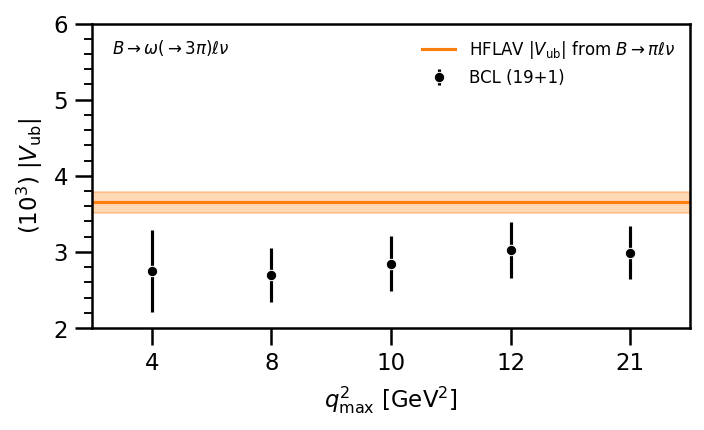

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

x = range(0, len(legacy_central))
ax.errorbar(
    x,
    [1e3 * result_legacy_varied_q2_fit[i].x[0] for i in x],
    yerr=[1e3 * result_legacy_varied_q2_fit[i].covariance[0, 0]**0.5 for i in x],
    marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='black', label='BCL (19+1)'
)

_vub = 1e3 * uncertainties.ufloat(3.65e-3, (0.09e-3**2 + 0.11e-3**2)**0.5)

ax.axhline(_vub.nominal_value,
        color="tab:orange", ls='solid',
        # label="LCSR, J. High Energ. Phys. (2016)\n"+r"$|V_\mathrm{ub}| = (3.65 \pm 0.09 \pm 0.11) \times 10^{-3}$")
        label=r"HFLAV $|V_\mathrm{ub}|$ from $B \rightarrow \pi \ell \nu$")
ax.fill_between([min(x)-0.5, max(x)+0.5], _vub.nominal_value - _vub.std_dev, _vub.nominal_value + _vub.std_dev, alpha=0.3, color="tab:orange")

del _vub

ax.set_xlim(min(x)-0.5, max(x)+0.5)
ax.set_ylim(2, 6)
ax.annotate(
    r'$B \rightarrow \omega (\rightarrow 3\pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 

ax.set_xticks(x, minor=False)
ax.set_xticklabels([f"{legacy_bins[i][1]}" for i in x], rotation='horizontal')
ax.tick_params(axis='x', which='minor', bottom=False)

ax.set_xlabel(r'$q^2_\mathrm{max}$ [GeV$^2$]')
ax.set_ylabel(r'$(10^3)$ $|V_\mathrm{ub}|$')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

## Fit: Individual Spectra, 19+1

In [54]:
def chi2_individual(x):
    babar_theory, belle_theory = predictor_BToVLNuBCL.get_theory_predictions(
        x, babar_bins, belle_bins)

    theory_res = lcsr_coefficients - x[1:]
    babar_res = babar_central - babar_theory
    belle_res = belle_central - belle_theory

    return theory_res @ theory_inverse @ np.transpose(theory_res) \
         + babar_res @ babar_inverse @ np.transpose(babar_res)\
         + belle_res @ belle_inverse @ np.transpose(belle_res)

In [55]:
%%time
result_individual = perform_fit(chi2_individual, x0=np.array([V_ub, *lcsr_coefficients]))

CPU times: user 6min 23s, sys: 655 ms, total: 6min 23s
Wall time: 6min 22s


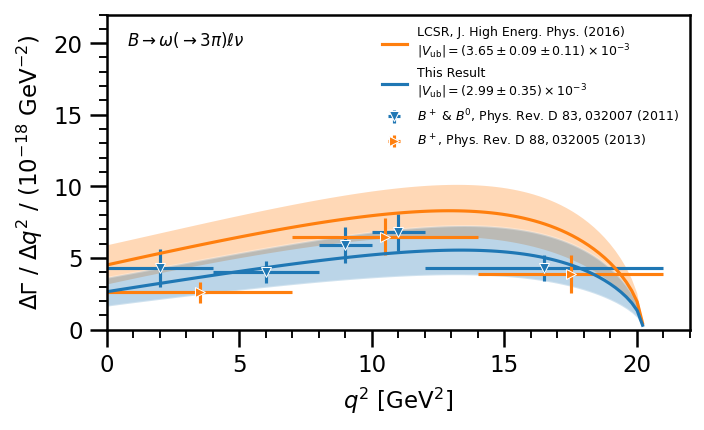

In [56]:
plotter_BToVLNuBCL = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=0)
q2 = np.linspace(plotter_BToVLNuBCL.q2min+1e-2, plotter_BToVLNuBCL.q2max-1e-2, num=100)

fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in babar_bins],
    [c for c in babar_central],
    yerr=[np.sqrt(babar_covariance[i, i]) for i in range(0, len(babar_bins))],
    xerr=[((b[1] - b[0]) / 2) for b in babar_bins],
    marker='v', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, label=r'$B^+$ & $B^0$, Phys. Rev. D 83, 032007 (2011)',
)

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in belle_bins],
    [c for c in belle_central],
    yerr=[np.sqrt(belle_covariance[i, i]) for i in range(0, len(belle_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in belle_bins],
    marker='>', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, label=r'$B^+$, Phys. Rev. D 88, 032005 (2013)'
)

# Plot HFLAV Vub + LCSR Coefficients
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(lcsr_coefficients, lcsr_coefficients_cov)
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(3.65e-3, (0.09e-3**2 + 0.11e-3**2)**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:orange", ls='solid',
        label="LCSR, J. High Energ. Phys. (2016)\n"+r"$|V_\mathrm{ub}| = (3.65 \pm 0.09 \pm 0.11) \times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:orange", alpha=0.3)

# Plot Fit Result
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(result_legacy.x[1:], result_legacy.covariance[1:, 1:])
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy.x[0], result_legacy.covariance[0, 0]**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:blue", ls='solid',
        label="This Result\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy.x[0]:.2f} \pm {1e3*result_legacy.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:blue", alpha=0.3, edgecolor="white", lw=1, ls="solid")

ax.set_xlim(0, 22)
ax.set_ylim(0, 22)
ax.annotate(
    r'$B \rightarrow \omega (\rightarrow 3\pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'$\Delta \mathcal{\Gamma}$ / $\Delta q^2$ / ($10^{-18}$ GeV$^{-2}$)')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=6)
plt.tight_layout()
plt.show()
plt.close()

## Fit: Legacy Spectrum 9+1

In [57]:
def chi2_legacy_9p1(x):
    legacy_theory = predictor_BToVLNuBCL.get_theory_predictions_9p1(x, legacy_bins)
    
    theory_res = lcsr_coefficients_9p1 - x[1:]
    legacy_res = legacy_central - legacy_theory

    return theory_res @ theory_inverse_9p1 @ np.transpose(theory_res) \
            + legacy_res @ legacy_inverse @ np.transpose(legacy_res)

In [58]:
%%time
result_legacy_9p1 = perform_fit(chi2_legacy_9p1, x0=np.array([V_ub, *lcsr_coefficients_9p1]))

CPU times: user 57.6 s, sys: 88.3 ms, total: 57.7 s
Wall time: 57.5 s


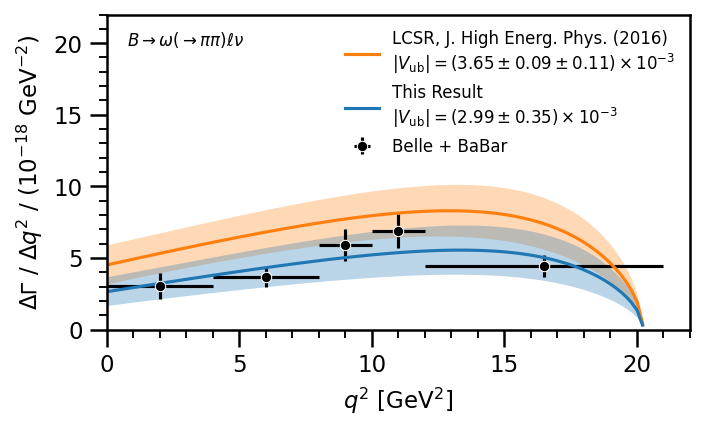

In [59]:
plotter_BToVLNuBCL = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=0)
q2 = np.linspace(plotter_BToVLNuBCL.q2min+1e-2, plotter_BToVLNuBCL.q2max-1e-2, num=100)

fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in legacy_bins],
    [c for c in legacy_central],
    yerr=[np.sqrt(legacy_covariance[i, i]) for i in range(0, len(legacy_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in legacy_bins],
    marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='black', label='Belle + BaBar'
)

# Plot HFLAV Vub + LCSR Coefficients
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(lcsr_coefficients, lcsr_coefficients_cov)
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(3.65e-3, (0.09e-3**2 + 0.11e-3**2)**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:orange", ls='solid',
        label="LCSR, J. High Energ. Phys. (2016)\n"+r"$|V_\mathrm{ub}| = (3.65 \pm 0.09 \pm 0.11) \times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:orange", alpha=0.3)

# Create padded vectors so the class can handle it
coefficients = np.array([*np.zeros(2), *result_legacy_9p1.x[1:], *np.zeros(8)])
coefficients_cov = np.zeros(lcsr_coefficients_cov.shape)
coefficients_cov[2:11, 2:11] = result_legacy_9p1.covariance[1:, 1:]

# Plot Fit Result
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(coefficients, coefficients_cov)
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy_9p1.x[0], result_legacy_9p1.covariance[0, 0]**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:blue", ls='solid',
        label="This Result\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy_9p1.x[0]:.2f} \pm {1e3*result_legacy_9p1.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:blue", alpha=0.3)

ax.set_xlim(0, 22)
ax.set_ylim(0, 22)
ax.annotate(
    r'$B \rightarrow \omega (\rightarrow \pi \pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'$\Delta \mathcal{\Gamma}$ / $\Delta q^2$ / ($10^{-18}$ GeV$^{-2}$)')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

## Summary: Cross-Checks

In [60]:
# label
parameter_labels = [
    r'$|V_\mathrm{ub}|$',
    r'$\alpha_1^{A_0}$', r'$\alpha_2^{A_0}$',
    r'$\alpha_0^{A_1}$', r'$\alpha_1^{A_1}$', r'$\alpha_2^{A_1}$',
    r'$\alpha_0^{A_{12}}$', r'$\alpha_1^{A_{12}}$', r'$\alpha_2^{A_{12}}$',
    r'$\alpha_0^{V}$', r'$\alpha_1^{V}$', r'$\alpha_2^{V}$',
    r'$\alpha_1^{T_1}$', r'$\alpha_2^{T_1}$',
    r'$\alpha_0^{T_2}$', r'$\alpha_1^{T_2}$', r'$\alpha_2^{T_2}$',
    r'$\alpha_0^{T_{23}}$', r'$\alpha_1^{T_{23}}$', r'$\alpha_2^{T_{23}}$',
]

# _lcsr_hflav
_central = np.array([3.65e-3, *lcsr_coefficients])
_cov = np.zeros(result_legacy.covariance.shape)
_cov[1:, 1:] = lcsr_coefficients_cov
_cov[0, 0] = (0.09e-3**2 + 0.11e-3**2)
_lcsr_hflav = uncertainties.correlated_values(_central, _cov)

# _result_legacy
_result_legacy = uncertainties.correlated_values(result_legacy.x, result_legacy.covariance)

# _result_legacy_sampled_ff
_result_legacy_sampled_ff = uncertainties.correlated_values(result_legacy_sampled_ff.x, result_legacy_sampled_ff.covariance)

# _result_individual
_result_individual = uncertainties.correlated_values(result_individual.x, result_individual.covariance)

# _result_legacy_9p1
_central = np.array([result_legacy_9p1.x[0], *np.zeros(2), *result_legacy_9p1.x[1:], *np.zeros(8)])
_cov = np.zeros(result_legacy.covariance.shape)
_cov[3:12, 3:12] = result_legacy_9p1.covariance[1:, 1:]
_cov[0, :] = np.array([result_legacy_9p1.covariance[0, 0], *np.zeros(2), *result_legacy_9p1.covariance[0, 1:], *np.zeros(8)])
_cov[:, 0] = _cov[0, :]
_result_legacy_9p1 = uncertainties.correlated_values(_central, _cov)

In [61]:
_result = pd.DataFrame.from_dict({
    "label": parameter_labels,
    "_lcsr_hflav": _lcsr_hflav,
    "_result_legacy": _result_legacy,
    "_result_legacy_sampled_ff": _result_legacy_sampled_ff,
    "_result_individual": _result_individual,
    "_result_legacy_9p1": _result_legacy_9p1,
})

In [62]:
print(tabulate(_result, headers=_result.columns, showindex=False, tablefmt="latex_raw"))

\begin{tabular}{llllll}
\hline
 label               & _lcsr_hflav       & _result_legacy    & _result_legacy_sampled_ff   & _result_individual   & _result_legacy_9p1   \\
\hline
 $|V_\mathrm{ub}|$   & 0.00365+/-0.00014 & 0.00299+/-0.00035 & 0.00299+/-0.00035           & 0.00298+/-0.00035    & 0.00299+/-0.00035    \\
 $\alpha_1^{A_0}$    & -0.83+/-0.30      & -0.94+/-0.28      & -0.94+/-0.28                & -0.94+/-0.28         & 0.0+/-0              \\
 $\alpha_2^{A_0}$    & 1.4+/-1.2         & 1.8+/-1.2         & 1.8+/-1.2                   & 1.7+/-1.2            & 0.0+/-0              \\
 $\alpha_0^{A_1}$    & 0.243+/-0.031     & 0.243+/-0.031     & 0.243+/-0.030               & 0.244+/-0.030        & 0.243+/-0.031        \\
 $\alpha_1^{A_1}$    & 0.34+/-0.24       & 0.30+/-0.22       & 0.29+/-0.22                 & 0.31+/-0.22          & 0.30+/-0.22          \\
 $\alpha_2^{A_1}$    & 0.1+/-0.6         & 0.0+/-0.5         & 0.0+/-0.5                   & 0.0+/-0.5            & 0.0+/-

# Summary Plots

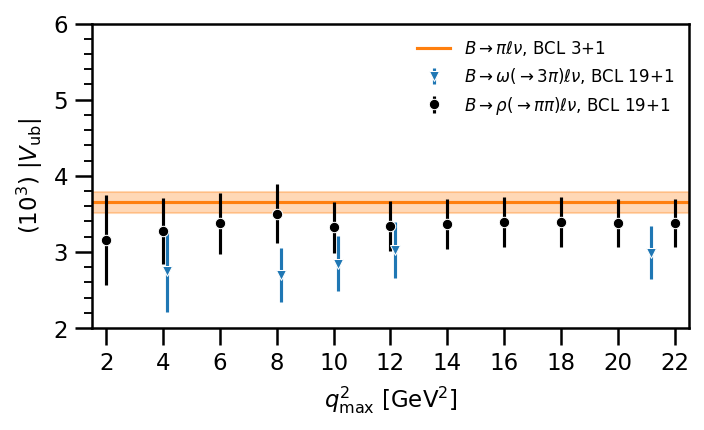

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

with open("../legacy_spectra/legacy_spectrum_omega.yaml", "r") as f:
    legacy_spectrum = yaml.load(f, Loader=yaml.FullLoader)

x = [np.array(legacy_spectrum["bins"])[i][1] for i in range(0, len(np.array(legacy_spectrum["bins"])))]
ax.errorbar(
    [xx+0.15 for xx in x],
    [1e3 * result_legacy_varied_q2_fit_omega[i].x[0] for i, _ in enumerate(x)],
    yerr=[1e3 * result_legacy_varied_q2_fit_omega[i].covariance[0, 0]**0.5 for i, _ in enumerate(x)],
    marker='v', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='tab:blue', label=r'$B \rightarrow \omega (\rightarrow 3\pi) \ell \nu$, BCL 19+1'
)

with open("../legacy_spectra/legacy_spectrum_rho.yaml", "r") as f:
    legacy_spectrum = yaml.load(f, Loader=yaml.FullLoader)    
    
x = [np.array(legacy_spectrum["bins"])[i][1] for i in range(0, len(np.array(legacy_spectrum["bins"])))]
ax.errorbar(
    x,
    [1e3 * result_legacy_varied_q2_fit_rho[i].x[0] for i, _ in enumerate(x)],
    yerr=[1e3 * result_legacy_varied_q2_fit_rho[i].covariance[0, 0]**0.5 for i, _ in enumerate(x)],
    marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='black', label=r'$B \rightarrow \rho (\rightarrow \pi \pi) \ell \nu$, BCL 19+1'
)

_vub = 1e3 * uncertainties.ufloat(3.65e-3, (0.09e-3**2 + 0.11e-3**2)**0.5)

ax.axhline(_vub.nominal_value,
        color="tab:orange", ls='solid',
        # label="LCSR, J. High Energ. Phys. (2016)\n"+r"$|V_\mathrm{ub}| = (3.65 \pm 0.09 \pm 0.11) \times 10^{-3}$")
        label=r"$B \rightarrow \pi \ell \nu$, BCL 3+1", zorder=1)
ax.fill_between([min(x)-0.5, max(x)+0.5], _vub.nominal_value - _vub.std_dev, _vub.nominal_value + _vub.std_dev, alpha=0.3, color="tab:orange")

del _vub

ax.set_xlim(min(x)-0.5, max(x)+0.5)
ax.set_ylim(2, 6)
#ax.annotate(
#    r'$B \rightarrow \rho (\rightarrow 3\pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
#    textcoords='offset points',
#    fontweight='bold', ha='left', va='top', fontsize=8
#) 

ax.set_xticks(x, minor=False)
#ax.set_xticklabels([f"{legacy_bins[i][1]}" for i in x], rotation='horizontal')
ax.tick_params(axis='x', which='minor', bottom=False)

ax.set_xlabel(r'$q^2_\mathrm{max}$ [GeV$^2$]')
ax.set_ylabel(r'$(10^3)$ $|V_\mathrm{ub}|$')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=8)
plt.tight_layout()
plt.savefig("../bcl_fits/q2max_vs_vub.png")
plt.savefig("../bcl_fits/q2max_vs_vub.pdf")
plt.show()
plt.close()